In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


%run nb_init.py
# This imports leg_joint as lj


/home/guillaume/anaconda/envs/tyssue/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1340: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)
2015-12-22 09:31:26,623 -leg_joint -INFO -successfully imported leg_joint


In [2]:
lj_eptm = lj.Epithelium(lj.data.small_xml(), save_dir='/tmp', copy=True)

2015-12-22 09:31:28,621 -leg_joint.epithelium -INFO -Instanciating epithelium 0
2015-12-22 09:31:29,343 -leg_joint.epithelium -INFO -Initial cells
2015-12-22 09:31:29,344 -leg_joint.epithelium -INFO -Initial junctions
2015-12-22 09:31:29,593 -leg_joint.epithelium -INFO -Update geometry


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline

import tyssue as ty
from tyssue.core.sheet import Sheet
from tyssue.core.generation import data_dicts
from tyssue.geometry import sheet_geometry as geom

In [5]:
graph = lj_eptm.graph
print('****** Vertex ********')
print(*graph.vertex_properties.keys(), sep='\n')
print('****** Edge ********')

print(*graph.edge_properties.keys(), sep='\n')

      

****** Vertex ********
volume_grad_cell
perimeters
grad_ix
thetas
sigmas
vols
ixs
zeds
is_cell_vert
grad_sigma
radial_tensions
grad_zed
volume_grad
is_alive
is_local_vert
rhos
contractilities
ages
grad_wy
vol_elasticities
contractile_grad
volume_grad_apical
wys
is_active_vert
grad_radial
prefered_vol
elastic_grad
volume_grad_radial
areas
****** Edge ********
u_dsigmas
dsigmas
u_dixs
is_junction_edge
is_active_edge
at_boundary
is_local_edge
dthetas
dzeds
line_tensions
u_dzeds
is_new_edge
u_drhos
edge_lengths
dixs
is_ctoj_edge
dwys
u_dwys
drhos


In [6]:
print('CELLS')
print(*data_dicts['face'].keys(), sep='\t')

print('JV')
print(*data_dicts['jv'].keys(), sep='\t')

print('JE')
print(*data_dicts['je'].keys(), sep='\t')

CELLS
x	is_alive	y	z	num_sides	perimeter	area
JV
x	z	y	is_active
JE
length	dz	srce	nx	face	trgt	dy	nz	ny	dx


In [7]:
jv_import = {'ixs': 'x', 'wys': 'y', 'zeds': 'z',
             'is_active_vert': 'is_active'}

cell_import = {'ixs': 'x', 'wys': 'y', 'zeds': 'z',
               'areas': 'area', 'perimeters': 'perimeter',
               'is_alive': 'is_alive'}

je_import = {'dixs': 'dx', 'dwys': 'dy', 'dzeds': 'dz',
             'edge_lengths': 'length'}

In [8]:
def get_faces(graph, as_array=True):
    '''
    Retrieves all the triangular subgraphs of the form
       1 -- > 2
        ^   ^
         \ /
          0
    In our context, vertex 0 always corresponds to a cell/face
    and vertices 1 and 2 to junction vertices

    Parameters
    ----------
    graph : a :class:`GraphTool` graph instance
    as_array: bool, optional, default `True`
      if `True`, the output of `subraph_isomorphism` is converted
      to a (N, 3) ndarray.

    Returns
    -------
    triangles:  list of gt.PropertyMaps or (N, 3) ndarray
      each line corresponds to a triplet (cell, jv0, jv1)
      where cell, jv0 and jv1 are indices of the input graph.
    '''
    tri_graph = gt.Graph()
    ## the vertices
    verts = tri_graph.add_vertex(3)
    ## edges
    tri_graph.add_edge_list([(0, 1), (0, 2), (1, 2)])
    _triangles = gt.subgraph_isomorphism(tri_graph, graph)
    if not as_array:
        return tri_graph, _triangles
    triangles = np.array([tri.a for tri in _triangles], dtype=np.int)
    return triangles

In [9]:
triangles = get_faces(graph)

The new base triangle is oriented differently, as the edge is splited.

We now have:

```
       1 -- > 2             2 <-- 1  
        ^   /                ^   /
         \ v     and          \ v  
          0                    0
```



In [10]:
pos = gt.group_vector_property([lj_eptm.ixs, lj_eptm.wys, lj_eptm.zeds])
deltas = gt.group_vector_property([graph.ep['dixs'], graph.ep['dwys'],  graph.ep['dzeds']])

oriented = []
for (cell, jv0, jv1) in triangles:
    
    normal = np.cross(deltas[graph.edge(cell, jv0)],
                      deltas[graph.edge(cell, jv1)])
    orientation = np.sign(np.sum(pos[graph.vertex(cell)] * normal))
    if orientation > 0:
        oriented.append([jv0, jv1, cell])
    else:
        oriented.append([jv1, jv0, cell])
    
    

In [14]:
graph.set_vertex_filter(lj_eptm.is_cell_vert)
cells_idx_in = graph.vertex_index.copy()
cells_idx_in = cells_idx_in.fa

graph.set_vertex_filter(lj_eptm.is_cell_vert, True)
jv_idx_in = graph.vertex_index.copy()
jv_idx_in = jv_idx_in.fa
graph.set_vertex_filter(None)



In [15]:
face_df = pd.DataFrame(index=pd.Index(range(cells_idx_in.shape[0]), name='face'), 
                       columns=cell_import.values())
face_df['old_idx'] = cells_idx_in

for data_in, data_out in cell_import.items():
    face_df[data_out] = graph.vp[data_in].a[cells_idx_in]

jv_df = pd.DataFrame(index=pd.Index(range(jv_idx_in.shape[0]), name='jv'), 
                       columns=jv_import.values())
jv_df['old_idx'] = jv_idx_in
    
    
for data_in, data_out in jv_import.items():
    jv_df[data_out] = graph.vp[data_in].a[jv_idx_in]



In [20]:
re_indexed = []
for jv0, jv1, face in oriented:
    srce = np.where(jv_df.old_idx==jv0)[0][0]
    trgt = np.where(jv_df.old_idx==jv1)[0][0]
    r_face = np.where(face_df.old_idx==face)[0][0]
    re_indexed.append((srce, trgt, r_face))
re_indexed = np.array(re_indexed)

In [21]:
re_indexed.shape

(272, 3)

In [23]:
#je_idx = pd.MultiIndex.from_tuples(re_indexed, names=['srce', 'trgt', 'cell'])
je_idx = pd.Index(np.arange(re_indexed.shape[0]), name='je')

je_df = pd.DataFrame(index=je_idx, columns=je_import.values())
je_df['srce'] = re_indexed[:, 0]
je_df['trgt'] = re_indexed[:, 1]
je_df['face'] = re_indexed[:, 2]


je_df['old_jv0'] = triangles[:, 1]
je_df['old_jv1'] = triangles[:, 2]
je_df['old_cell'] = triangles[:, 0]


eps = gt.group_vector_property([graph.ep[col] for col in je_import.keys()])


#for halfedge in je_idx:
    
#    je_df[[v for v in je_import.values()]].loc[halfedge] = eps[graph.edge(je_df.old_jv0.loc[halfedge],
#                                                             je_df.old_jv1.loc[halfedge])]

In [36]:
normal = np.cross(deltas[graph.edge(0, 56)],
                  deltas[graph.edge(0, 57)])
orientation = np.sign(np.sum(pos[graph.vertex(0)] * normal))
print(orientation)

-1.0


In [24]:
je_df.head()


,dx,dz,dy,length,srce,trgt,face,old_jv0,old_jv1,old_cell
je,,,,,,,,,,
0,NaN,NaN,NaN,NaN,1,0,0,56,57,0
1,NaN,NaN,NaN,NaN,2,1,0,57,58,0
2,NaN,NaN,NaN,NaN,0,1,1,56,57,1
3,NaN,NaN,NaN,NaN,3,0,1,56,59,1
4,NaN,NaN,NaN,NaN,1,6,1,57,62,1


In [26]:
with pd.get_store('small_hexagonal.hf5') as store:
    store.put('face_df', face_df, format='t', dropna=False)
    store.put('jv_df', jv_df, format='t', dropna=False)
    store.put('je_df', je_df, format='t', dropna=False)

In [39]:
datasets = {'je': je_df, 'jv': jv_df, 'face': face_df}

In [40]:
sheet = Sheet('imported', datasets, data_dicts)

In [41]:
sheet.set_geom(geom)

{'face': {'num_sides': (6, int)},
 'je': {'nx': (0.0, float), 'ny': (0.0, float), 'nz': (0.0, float)},
 'jv': {'basal_shift': (4.0, float), 'rho': (0.0, float)},
 'settings': {'geometry': 'cylindrical', 'height_axis': 'z'}}

In [42]:
geom.update_all(sheet)

In [43]:
sheet.je_df.head()

,dx,dz,dy,length,srce,trgt,face,old_jv0,old_jv1,old_cell,ny,nz,nx,sub_area,sub_vol
je,,,,,,,,,,,,,,,
0,0.369491,-1.10053,-1.857558,2.190482,1,0,0,56,57,0,7.823193e-01,-6.863514e-01,1.888686,1.078220e+00,9.208356e-01
1,1.052222,1.10053,-1.574762,2.190482,2,1,0,57,58,0,-2.220446e-16,-3.330669e-16,0.000000,2.001483e-16,1.709332e-16
2,-0.369491,1.10053,1.857558,2.190482,0,1,1,56,57,1,5.421817e-01,4.575676e-01,4.088597,2.074847e+00,1.771988e+00
3,0.369491,-1.10053,1.857558,2.190482,3,0,1,56,59,1,-5.421817e-01,4.575676e-01,4.088597,2.074847e+00,1.771988e+00
4,0.000000,2.20106,0.000000,2.201060,1,6,1,57,62,1,2.710909e-01,-0.000000e+00,4.088597,2.048787e+00,1.749732e+00


In [44]:
from tyssue.draw.mpl_draw import sheet_view


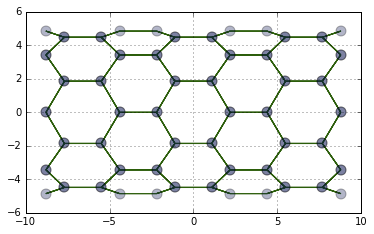

In [46]:
fig, ax = sheet_view(sheet, coords=['z', 'x'])